In [2]:
from tars import Tars, markets, portfolios, traders, strategies

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


# Koker strategy - in development

Here's an example to show how you can develop your own strategy. This notebook is a template for you to start your own thing.

https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application/

### Here's the strategy in development

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


class Koker:

    def __init__(self):
        self.x = None
        self.x_train = None
        self.x_test = None
        self.theta = None
        self.sharpes = None

    def load(self, data):
        """
        Load a dataframe with the data and create the training and test set.
        The column with the timestamp must be the index and the one with
        price, "close".

        :param data: DataFrame
        """
        data.index = pd.to_datetime(data.index, unit='s')
        rets = data['close'].diff()[1:]

        x = np.array(rets)
        self.x = x

        N = 4000
        P = 800
        x_train = x[-(N+P):-P]
        x_test = x[-P:]

        # Normalize with Z-Score
        std = np.std(x_train)
        mean = np.mean(x_train)

        self.x_train = (x_train - mean) / std
        self.x_test = (x_test - mean) / std

    @staticmethod
    def sharpe_ratio(rets):
        return rets.mean() / rets.std()

    @staticmethod
    def positions(x, theta):
        M = len(theta) - 2
        T = len(x)
        Ft = np.zeros(T)
        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
            Ft[t] = np.tanh(np.dot(theta, xt))
        return Ft

    @staticmethod
    def returns(Ft, x, delta):
        T = len(x)
        rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
        return np.concatenate([[0], rets])

    @staticmethod
    def gradient(x, theta, delta):
        Ft = Koker.positions(x, theta)
        R = Koker.returns(Ft, x, delta)
        T = len(x)
        M = len(theta) - 2

        A = np.mean(R)
        B = np.mean(np.square(R))
        S = A / np.sqrt(B - A ** 2)

        dSdA = S * (1 + S ** 2) / A
        dSdB = -S ** 3 / 2 / A ** 2
        dAdR = 1. / T
        dBdR = 2. / T * R

        grad = np.zeros(M + 2)  # initialize gradient
        dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta

        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
            dRdF = -delta * np.sign(Ft[t] - Ft[t - 1])
            dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t - 1])
            dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
            dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (
                        dRdF * dFdtheta + dRdFp * dFpdtheta)
            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

        return grad, S

    def train(self, x, epochs=2000, M=8, commission=0.0025, learning_rate=0.3):
        theta = np.random.rand(M + 2)
        sharpes = np.zeros(epochs)  # store sharpes over time
        for i in tqdm(range(epochs)):
            grad, sharpe = Koker.gradient(x, theta, commission)
            theta = theta + grad * learning_rate
            sharpes[i] = sharpe
        self.theta = theta
        self.sharpes = sharpes

    def plot(self, x, theta):
        """
        Probably to delete
        """
        x_returns = Koker.returns(Koker.positions(x, theta), x, 0.0025)
        plt.plot(x_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
        plt.plot(x.cumsum(), label="Buy and Hold", linewidth=1)
        plt.xlabel('Ticks')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.title("RL Model vs. Buy and Hold")


## Test the RL algorithm

In [4]:
from tars.utils import data 
df = data.get_historical_ohlc_data(base='ETH', quote='USD', data_folder='../../data/raw')
df.shape

(501993, 6)

## Model

In [8]:
koker = Koker()
koker.load(df)
koker.train(koker.x_train, epochs=800)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:42<00:00,  7.78it/s]


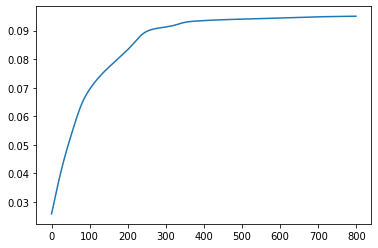

In [12]:
plt.plot(koker.sharpes);

## Train

In [13]:
train_returns = koker.returns(koker.positions(koker.x_train, koker.theta), koker.x_train, 0.0025)

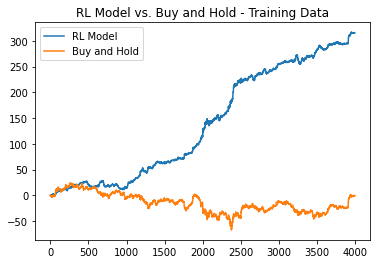

In [14]:
plt.plot(train_returns.cumsum(), label="RL Model")
plt.plot(koker.x_train.cumsum(), label="Buy and Hold")
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

## Test

In [15]:
test_returns = koker.returns(koker.positions(koker.x_test, koker.theta), koker.x_test, 0.0025)

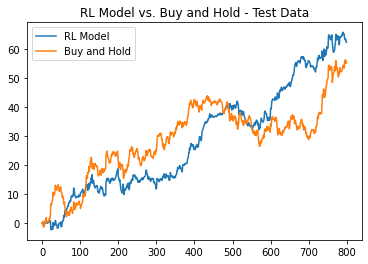

In [16]:
plt.plot(test_returns.cumsum(), label="RL Model")
plt.plot(koker.x_test.cumsum(), label="Buy and Hold")
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

## Create the full Koker Strategy

In [21]:
import pandas as pd
from ta.trend import MACD

from pandas import DataFrame, Timestamp

from tars.utils import data 
from tars.evaluators.trader_evaluator import TraderEvaluator
from tars.strategies.abstract_strategy import AbstractStrategy
from tars.markets.crypto_market import CryptoMarket


class KokerStrategy(AbstractStrategy):
    """
    Koker Strategy

    :param trader: Trader
        The Trader handling a portfolio
    :param pair: str
        The pair e.g. XETHZUSD to buy and hold
    :param volume: float
        The volume of the pair's quote buy
    :param validate: boolean
        Safety Boolean to make sure not to trade real money by default

    :ivar evaluator: AbstractEvaluator
        Evaluator allows for the evaluation of a strategy
    :ivar market: AbstractMarket
        Market object to get information from
    """

    def __init__(self, trader, pair, volume, validate=True):
        self.name = 'Koker Strategy'
        self.trader = trader
        self.pair = pair
        self.volume = volume
        self.validate = validate
        self.evaluator = TraderEvaluator(self.trader)
        
        self.is_trained = False
        self.koker = None
        self.decisions = []
        
    def train(self):
        """ Train the Koker model and save it for usage in run"""
        
        # Get the data
        df = data.get_historical_ohlc_data(base='ETH', quote='USD', data_folder='../../data/raw')
        
        # Create model
        koker = Koker()
        koker.load(df)
        koker.train(koker.x_train, epochs=800)
        
        # Save for usage in runs
        return koker
        

    def run(self):
        """ Run the strategy """
        # 0. Train model
        # This happens only once at the beginning of the trading session
        if not self.is_trained:
            self.koker = self.train()
            self.is_trained = True
        
        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance().loc['eb'].ZUSD   
        self.evaluator.add_checkpoint(Timestamp.utcnow(), balance)
        
        # 2. Process the data
        df0 = self.trader.market.get_ohlc_data(pair=self.pair)[0]['close'].iloc[::-1]
        last_9_close = df0[-9:]

        # 3. Get the model output given the data.
        # the variable 'decision' is giving a value between [-1, 1] that is a ratio of the volume to buy or sell.
        decision = self.koker.positions(last_9_close, self.koker.theta)[-1]
        
        
        # 4. Implement the trading logic
        if decision < 0:
            volume_to_sell = self.volume * decision
            self.trader.add_order(pair=self.pair, type='sell',
                                  ordertype='market', volume=volume_to_sell,
                                  validate=self.validate)
        elif decision > 0:
            volume_to_buy = self.volume * decision
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=volume_to_buy,
                                  validate=self.validate)
        else:
            pass
        
        
    
    def test(self, dtime: Timestamp, data: DataFrame):
        """ test the strategy """
        # 0. Train model
        # This happens only once at the beginning of the trading session
        if not self.is_trained:
            self.koker = self.train()
            self.is_trained = True
        
        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance(dtime).loc['eb'].ZUSD
        self.evaluator.add_checkpoint(dtime, balance)
        
        # 2. Process the data
        df0 = self.trader.market.get_ohlc_data(pair=self.pair)[0]['close'].iloc[::-1]
        last_9_close = df0[-9:]

        # 3. Get the model output given the data.
        # the variable 'decision' is giving a value between [-1, 1] that is a ratio of the volume to buy or sell.
        decision = self.koker.positions(last_9_close, self.koker.theta)[-1]
        self.decisions.append(decision)
        
        # 4. Implement the trading logic
        if decision < 0:
            volume_to_sell = self.volume * decision
            self.trader.add_order(dtime=dtime, pair=self.pair, type='sell',
                                  ordertype='market', volume=volume_to_sell,
                                  validate=self.validate)
        elif decision > 0:
            volume_to_buy = self.volume * decision
            self.trader.add_order(dtime=dtime, pair=self.pair, type='buy',
                                  ordertype='market', volume=volume_to_buy,
                                  validate=self.validate)
        else:
            pass
        


## Instanciate Tars

Then, it is as usual.

In [22]:
api_key = f'../kraken.key'

In [23]:
my_data = data.get_historical_ohlc_data(base='ETH', quote='USD', interval=720, data_folder='../../data/raw/')['2021':]
market = markets.HistoricalMarket()
market.load('XETHZUSD', my_data)

In [24]:
portfolio_1 = portfolios.HistoricalPortfolio(market, {'ZUSD': 1000})
trader_1 = traders.HistoricalTrader(market, portfolio_1)
strategy_1 = KokerStrategy(trader_1, 'XETHZUSD', 0.2)

portfolio_2 = portfolios.HistoricalPortfolio(market, {'ZUSD': 1000})
trader_2 = traders.HistoricalTrader(market, portfolio_2)
strategy_2 = strategies.BuyAndHold(trader_2, 'XETHZUSD', 0.2)

In [25]:
# Create Tars and load its strategies
tars = Tars()
tars.load(strategy_1)
tars.load(strategy_2)

 🤖 TARS : Welcome to Endurance! 👨‍🚀
 🤖 TARS : Loaded strategy ➡️ Koker Strategy
 🤖 TARS : Loaded strategy ➡️ Buy and hold


## Start the bot

## Evaluate the strategy

In [26]:
tars.test(my_data.tail(1000))

 🤖 TARS : Starting backtesting session 📈
 💪️ Loading :   
   🧵 'Thread-14' ➡️ 'Koker Strategy'
   🧵 'Thread-15' ➡️ 'Buy and hold'


100%|████████████████████████████████████████████| 800/800 [01:42<00:00,  7.80it/s]


A


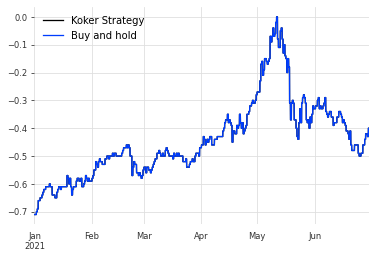

In [13]:
tars.evaluate(metric='cumulative return').plot();

In [14]:
tars.evaluate().tail()

,Koker Strategy,Buy and hold
2021-06-30 11:56:00,596.84,596.84
2021-06-30 11:57:00,596.84,596.84
2021-06-30 11:58:00,596.84,596.84
2021-06-30 11:59:00,596.84,596.84
2021-06-30 12:00:00,596.84,596.84


## Stop the bot

In [28]:
tars.stop()

 🤖 TARS : ✋ Stopped all strategies


---